# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from scipy.stats import pearsonr 

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, precision_score,\
                            f1_score, confusion_matrix,\
                            precision_recall_curve, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay, make_scorer

import seaborn as sns

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.expand_frame_repr', 500)
os.chdir(r'C:\Users\Grine\Desktop\GitHub\YandexPracticum\5 ОБУЧЕНИЕ С УЧИТЕЛЕМ\\')
RANDOM_STATE = 42

## Подготовка данных

In [2]:
data = pd.read_csv('Churn.csv')

In [3]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
# преобразование колонок из Верблюжего регистра к стандарту PEP-8
data.columns = [(('_'.join(re.findall('[A-Z][^A-Z]*', name))).lower()) for name in data.columns]

In [5]:
data.isna().sum()

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

**Есть пропуски по признаку tenure, проанализируем как мы можем заменить этот признак.**

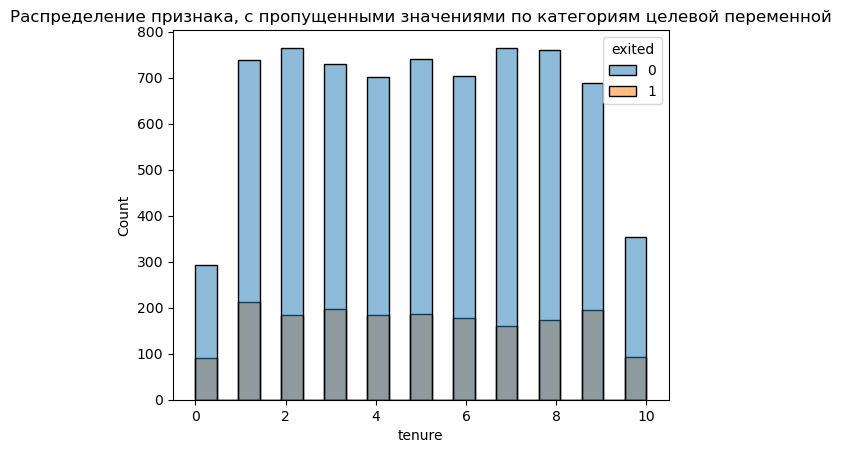

In [6]:
plt.title('Распределение признака, с пропущенными значениями по категориям целевой переменной')

sns.histplot(x=data['tenure'],
             hue=data['exited'],
             label='целевая переменная')
plt.show();

**На первый взгляд видно, что прямой взаимосвязи нет, между выбранным признаком и целевой переменной. Проведём ещё анализ корреляции, перед тем, как сделать вывод о том, как заполнить пропуск:**

    H0: связи между признаками статистически не значима, можно заменять пропуски, любым доступным методом;
    H1: связь между признаками статистически значима, надо использовать консервативные подходы к замене признаков; 

In [7]:
clean_array = data[data['tenure'].notna()]
array_1, array_2 = clean_array['tenure'], clean_array['exited']

pearson = pearsonr(array_1, array_2)

if pearson.pvalue < 0.05:
    print('Принимаем H1')
else:
    print('Принимаем H0')

Принимаем H0


**Поскольку мы приняли H0, то заменим пропуски в данном признаке на "-1"**

In [8]:
data['tenure'].fillna(-1, inplace=True)

In [9]:
data.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure              float64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

*снизим тип данных для экономии оперативки*

In [10]:
float_data = data.select_dtypes(include='float64').columns
int_data =data.select_dtypes(include='int64').columns

data[float_data] = data[float_data].astype('float32')
data[int_data] = data[int_data].astype('int32')

*Изучим признаки в формате "object".*

In [11]:
serieses_with_type_object = data.select_dtypes('object')
serieses_with_type_object.head(2)

,surname,geography,gender
0,Hargrave,France,Female
1,Hill,Spain,Female


In [12]:
print("Количество уникальных фамилий:", len(set(serieses_with_type_object.iloc[:, 0])))
print("Список уникальных стран в выборке:", set(serieses_with_type_object.iloc[:, 1]))
print("Список уникальных гендеров в выборке:", set(serieses_with_type_object.iloc[:, 2]))

Количество уникальных фамилий: 2932
Список уникальных стран в выборке: {'France', 'Germany', 'Spain'}
Список уникальных гендеров в выборке: {'Male', 'Female'}


*Удалим столбец с фамилиями. Остальные столбцы преобразуем с помощью Дамми-переменных.*

In [13]:
data = data.drop(columns='surname', axis=1)

In [14]:
data = pd.get_dummies(data) 

In [15]:
# Дополнительно из модели стоит удалить такие столбцы, как: row и customer-id. 
# вряд-ли порядковый номер строки и порядковый номер клиента поспособствуют улучшению качества модели
data = data.drop(columns=['row_number', 'customer_id'])

In [16]:
data.to_csv('predared_data.csv',
            index=False,
            encoding='cp1252',
            sep=';')

In [17]:
pd.read_csv('predared_data.csv',
            encoding='cp1252',
            sep=';')

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,1,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,1,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,1,0,0,1,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,0,1,0,0,1


### Исследование задачи

In [18]:
# Создадим 2 группы данных. Целевой признак и все остальные
target = data['exited'] 
features = data.drop(columns=['exited'], axis=1) 

In [19]:
X_train, X_tech, y_train, y_tech = train_test_split(
    features, target, test_size=0.4, random_state=RANDOM_STATE, stratify=data['exited'])

X_val, X_test, y_val, y_test = train_test_split(
    X_tech, y_tech, test_size=0.5, random_state=RANDOM_STATE, stratify=y_tech) 


print('Объём выборки для обучения:', "{0:.0%}".format(X_train.shape[0]/features.shape[0]))
print('Объём выборки для валидации:', "{0:.0%}".format(X_val.shape[0]/features.shape[0]))
print('Объём выборки для теста:', "{0:.0%}".format(X_test.shape[0]/features.shape[0]))

Объём выборки для обучения: 60%
Объём выборки для валидации: 20%
Объём выборки для теста: 20%


Прибегнем к методу масштабизации признаков. Чтобы избежать утечки признаков. В качестве метода масштабизации будем применять метод стандртизации

In [20]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

In [21]:
scaler = StandardScaler()
scaler.fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])
X_val[numeric] = scaler.transform(X_val[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

**Данные разбиты на выборки и приведены к станадртному виду. Теперь можно проводить пробное обучение**

## Построим BASELINE модель

In [22]:
baseline = LogisticRegression(random_state=RANDOM_STATE)

baseline.fit(X_train, y_train)

def estimator(model=baseline, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val):
    """
    Функция для оценки модели логистической регрессии.
    
    Параметры:
    model: обученная модель, по умолчанию baseline (логистическая регрессия)
    X_train: тренировочные данные
    y_train: метки тренировочных данных
    X_val: валидационные данные
    y_val: метки валидационных данных

    Функция выводит метрики F1 на тренировочных и валидационных данных, 
    а также строит ROC-кривую и матрицу путаницы.
    """

    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    pred_proba_val = model.predict_proba(X_val)[:, 1]

    f1_train = f1_score(y_train, pred_train)
    f1_val = f1_score(y_val, pred_val)
    roc_auc = roc_auc_score(y_val, pred_proba_val)

    print('F1-мера, тренировочные данные:', f1_train.round(2), '\n',
          'F1-мера, валидационные данные:', f1_val.round(2), '\n',
          'Значение ROC-AUC:', roc_auc.round(2))

    fpr, tpr, _ = roc_curve(y_val, pred_proba_val)
    roc_auc = auc(fpr, tpr)
    
    cm = confusion_matrix(y_val, pred_val)

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    ax[0].plot([0, 1], [0, 1], 'k--', label='No Skill')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC-кривая')
    ax[0].legend()

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

F1-мера, тренировочные данные: 0.3 
 F1-мера, валидационные данные: 0.32 
 Значение ROC-AUC: 0.79


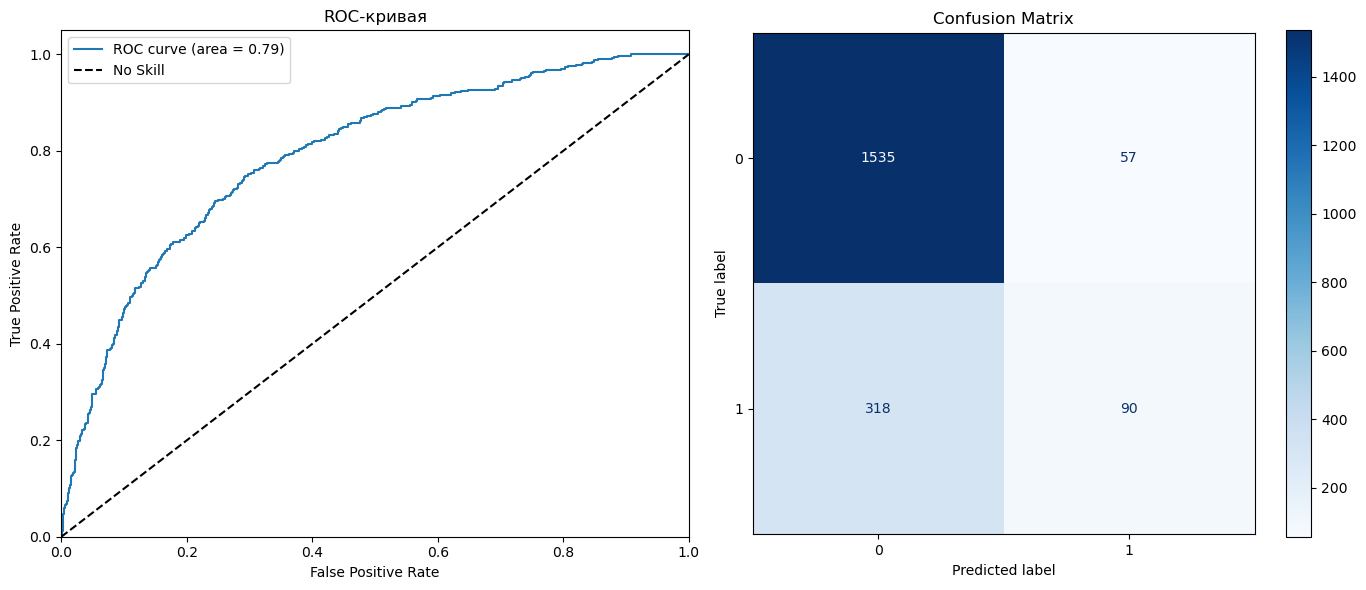

In [23]:
estimator()

Ранжирующая способность BASELINE Модели оставляет желать лучшего. 
Мы видим очень сильный дисбаланс на уровне предсказанных значений. Для повышения качества Модели рекомендуется проработать проблему дисбаланса классов. Но для начала оценим масштаб расхождений классов

In [24]:
print(f'Процент положительных меток: {round(target.sum()/len(target)*100, 2)}%')

Процент положительных меток: 20.37%


## Борьба с дисбалансом

Для борьбы с дисбалансом будет применяно 3 метода:

    1) апсемплинг;
    2) даунспелинг;
    3) взвешивание классов;
    
Сначала проведём обучение моделей на каждом из методе, а потом посмотрим итоговые результаты.

### Upsempling

C помощью метода SMOTE импортированного из библиотеки imblearn, избавим от дисбаланса класса (метод увеличиваем выборку с меньшим классом).

F1-мера, тренировочные данные: 0.74 
 F1-мера, валидационные данные: 0.52 
 Значение ROC-AUC: 0.79


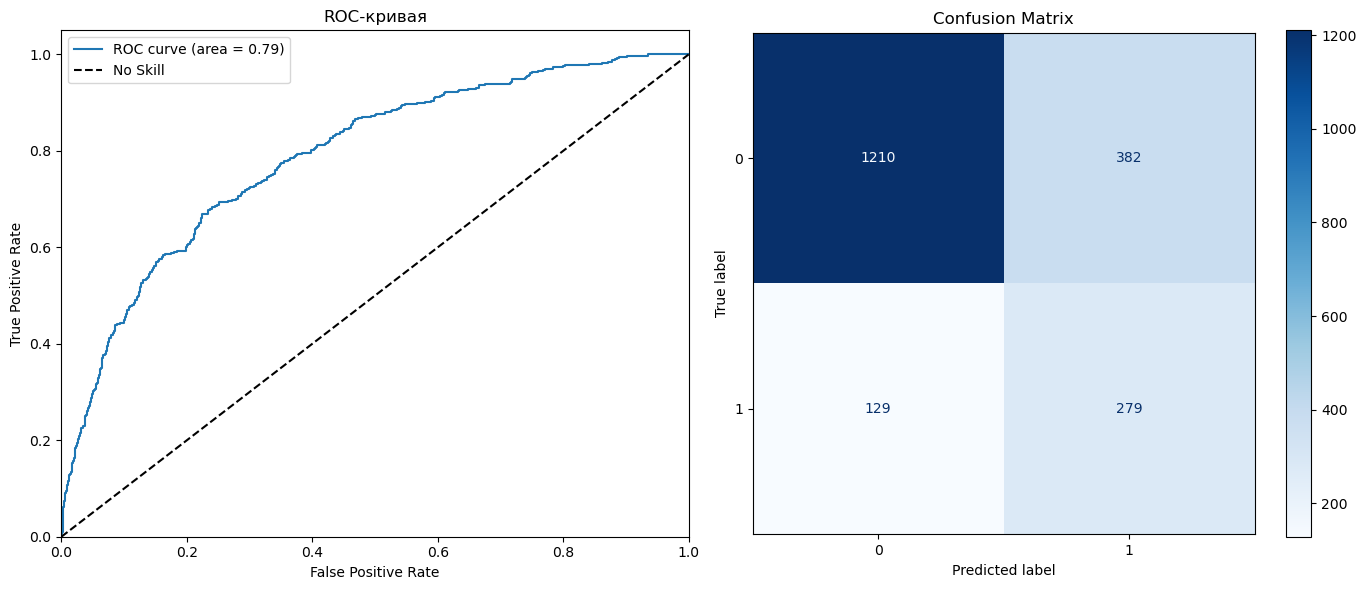

In [25]:
oversample = SMOTE(random_state=RANDOM_STATE)
X_train_up, y_train_up = oversample.fit_resample(X_train, y_train)

baseline_up = LogisticRegression(random_state=RANDOM_STATE)

baseline_up.fit(X_train_up, y_train_up)

estimator(model=baseline_up, X_train=X_train_up, y_train=y_train_up)

### Downsempling

F1-мера, тренировочные данные: 0.7 
 F1-мера, валидационные данные: 0.52 
 Значение ROC-AUC: 0.79


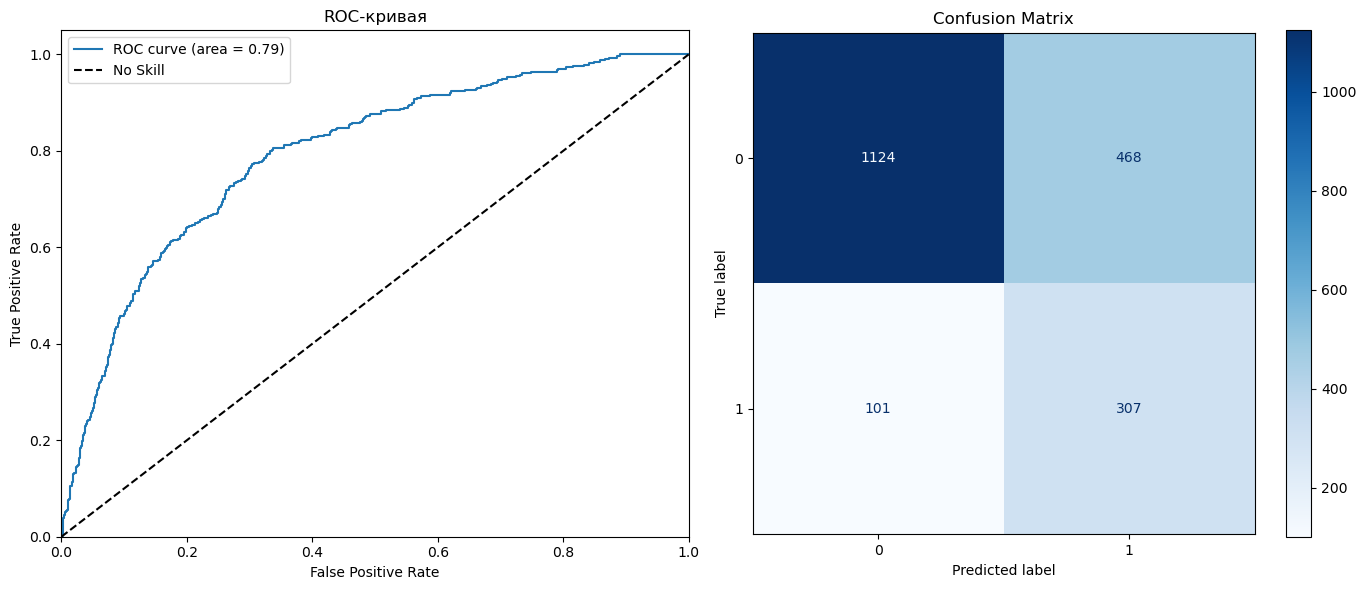

In [26]:
undersample = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_down, y_train_down = undersample.fit_resample(X_train, y_train)

baseline_down = LogisticRegression(random_state=RANDOM_STATE)

baseline_down.fit(X_train_down, y_train_down)

estimator(model=baseline_down, X_train=X_train_down, y_train=y_train_down)

### Class-weight-balance

F1-мера, тренировочные данные: 0.49 
 F1-мера, валидационные данные: 0.52 
 Значение ROC-AUC: 0.79


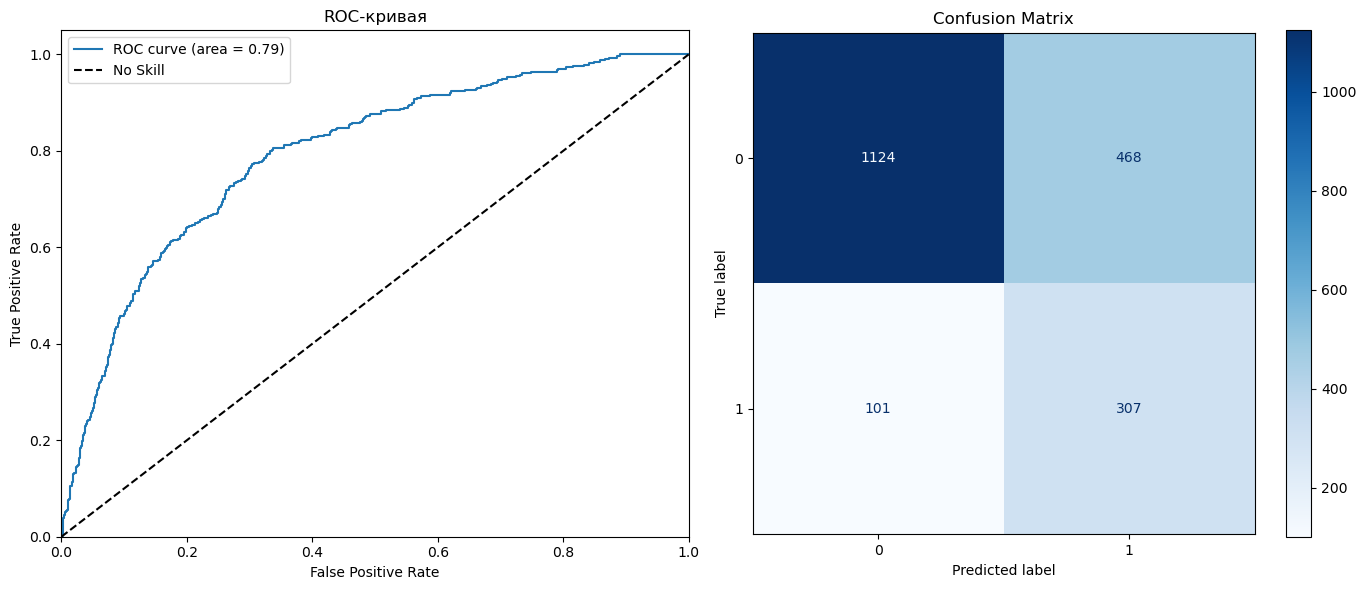

In [27]:
baseline_wg = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

baseline_wg.fit(X_train, y_train)

baseline_wg.fit(X_train_down, y_train_down)

estimator(model=baseline_wg)

**Самым лучшим методом оказался UPSEMPLING. Будем использовать данные для дальнейшего обучения: X_train_up, y_train_up**

In [28]:
del X_train_down, y_train_down, baseline_down, baseline_wg

## Подбор Модели

In [37]:
# Определение параметров для GridSearchCV
param_grid_log = {
    'C': [0.1, 0.2, 0.3, 0.4, 1, 2, 5],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' поддерживает 'l1' и 'l2' penalties
}

# Определение модели логистической регрессии
model_log_reg = LogisticRegression(random_state=RANDOM_STATE)

# Настройка GridSearchCV
clf_log_reg = GridSearchCV(
    estimator=model_log_reg,
    param_grid=param_grid_log,
    scoring=f1,
    n_jobs=-1,
    cv=3
)

# Обучение модели
clf_log_reg.fit(X_train_up, y_train_up)

# Вывод лучших результатов
print('Лучший результат F1-меры: {:.2f}'.format(clf_log_reg.best_score_))
print('Лучшие параметры: \n', clf_log_reg.best_params_)

Лучший результат F1-меры: 0.74
Лучшие параметры: 
 {'C': 0.2, 'penalty': 'l1', 'solver': 'liblinear'}


**Логистическая регрессия не справляется. Попробуем случайный лес**

In [46]:
# Определение параметров для GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Определение модели случайного леса
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Настройка GridSearchCV
clf_rf = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid_rf,
    scoring=f1,
    n_jobs=-1,
    cv=3
)

# Обучение модели
clf_rf.fit(X_train_up, y_train_up)

# Вывод лучших результатов
print('Лучший результат F1-меры: {:.2f}'.format(clf_rf.best_score_))
print('Лучшие параметры: \n', clf_rf.best_params_)

Лучший результат F1-меры: 0.83
Лучшие параметры: 
 {'bootstrap': False, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


**Случайный лес полностью выполняет требование, поставленное заказчиком. Проведём тестирование нашей Модели**

## Тестирование модели

**На завершающем этапе необходимо протестировать отобранную модель.**

F1-мера, тренировочные данные: 0.86 
 F1-мера, валидационные данные: 0.61 
 Значение ROC-AUC: 0.85


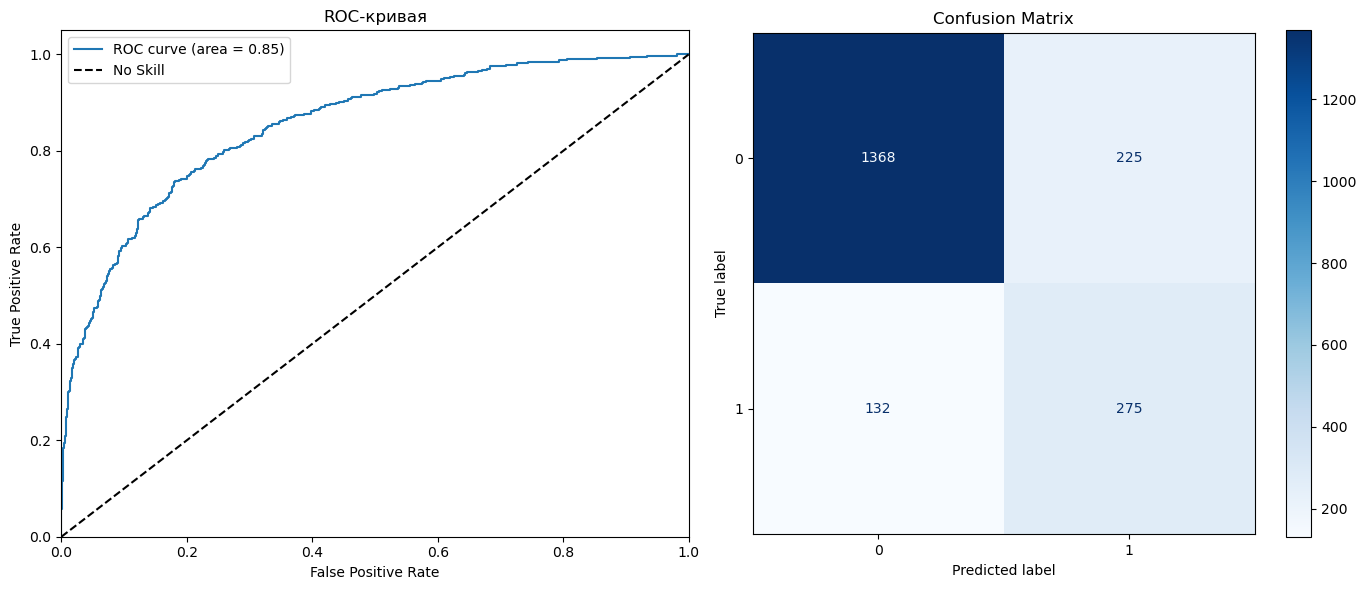

RECALL_score: 0.68


In [55]:
best_model = clf_rf.best_estimator_
estimator(model=best_model, X_train=X_train_up, y_train=y_train_up,  X_val=X_test, y_val=y_test)

preds = best_model.predict(X_test)
true = y_test
print('RECALL_score:', round(recall_score(true, preds), 2))

**Общий вывод:**

В ходе исследования была проведена подготовка и предобработка данных, с помощью этих данных было проведено тренировочное тестирование 3 моделей: baseline (логистическая регрессия), логистическая регрессия с подбором гиперпараметров, случайный лес.
Первое тренировочное тестирование показало, что сделать корректную модель не проработов с дисбалансом классов - в данном случае не получится. Поэтому была проведена аналитика дисбалансов классов. Было использовано 3 подхода:

    1) апсемплинг;
    2) даунсеплинг;
    3) взвешивание классов.
 
В результате проведения тестирований, был отобран наиболее оптимальный подход, а именнно - UPSEMPLING.
В результате тестирования моделей с новым подходоим борьбы с дисбалансом, была выбрана лучшая модель. 
Модель - случайного леса, с гиперпараметрами:
        
        {'bootstrap': False, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200.}
        

Эта модель также была обкатана на тестовых данных. В резульатет чего, F1-мера модели составила 0.61, что больше, чем требовалось в первоисходной задаче. Модель была протестирована на случайных данных и также показала свою эффективность.
Была также оценена плотность модели, говорящая о том, какую долю верных предсказаний отразила модель. Эта доля составлиа 0.61, т.е. модель с ~61% вероятностью определяет, с каким клиентом нужно поработать маркетолагам из "Бета-Банка". Этого достаточно, учитывая какие данные нам доступны.